In [1]:
%cd /kaggle/input/chemcancer-v2/src/
%mkdir /kaggle/working/Machine_Learning_models/
%mkdir /kaggle/working/Machine_Learning_models_results/

/kaggle/input/chemcancer-v2/src


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tensorflow.keras.optimizers import Adam
from data import *
from machine_learning_models import *
from deep_learning_models import *
from vision_transformer import *
from utils_dl_model import *
from utils_ml_model import print_ml_results
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
# Set the seed value.
SEED = 7
np.random.seed(SEED)

# Deep Learning parameters
DL_EPOCH = 500
DL_BATCH_SIZE = 32
DL_CNN_VERSION = 3
DL_TRANSFORMER_VISION_VERSION = 11
DL_BLS_VERSION = 1

DO_DL = False
CV_DL = True
OPT_DL = False

DO_CNN = False
DO_TRANSFORMER_VISION = False
DO_BLS = False
DO_ML = True

# Percentage of test set out of the dataset.
TEST_SET = 0.2

# Percentage of validation set out of the training dataset.
VAL_SET = 0.2

# Folder path associated with machine learning models
ml_models_folder = "/kaggle/working/Machine_Learning_models/"
ml_models_results_folder = "/kaggle/working/Machine_Learning_models_results/"

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def compute_tp_tn_fp_fn_percentage(y_test, y_pred, class_label):
    """
    Function to compute the True Positives (TP), True Negatives (TN),
    False Positives (FP), and False Negatives (FN) for a specific class as percentages.
    """
    cm = confusion_matrix(y_test, y_pred)
    total_samples = np.sum(cm)

    tp = cm[class_label, class_label] / total_samples
    fp = (sum(cm[:, class_label]) - cm[class_label, class_label]) / total_samples
    fn = (sum(cm[class_label, :]) - cm[class_label, class_label]) / total_samples
    tn = (total_samples - (tp + fp + fn)) / total_samples

    return tp, tn, fp, fn

# Replace compute_tp_tn_fp_fn with compute_tp_tn_fp_fn_percentage in the function train_and_evaluate_ml_models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def train_and_evaluate_ml_models(models, X_augmented, y_augmented, X_test, y_test, apply_pca=False, pca_variance_threshold=0.95, apply_filters_bg_subtraction=False, cv=5, standardize_data_func=None):
    results = {}

    # Create a StratifiedKFold object for cross-validation on the augmented data
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    for name, model in models.items():
        fold_metrics = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1_score': [],
            'confusion_matrix': [],
            'tp_tn_fp_fn': []
        }

        # Perform stratified cross-validation on the augmented data
        for train_index, _ in skf.split(X_augmented, y_augmented):
            X_train_fold, y_train_fold = X_augmented[train_index], y_augmented[train_index]
            X_test_fold = X_test
            
            # Apply filters and background subtraction if enabled
            if apply_filters_bg_subtraction:
                X_train_fold = apply_filters_and_background_subtraction(X_train_fold)
                X_test_fold = apply_filters_and_background_subtraction(X_test)
                
            # Standardize data if a standardization function is provided
            if standardize_data_func is not None:
                X_train_fold, X_test_fold = standardize_data_func(X_train_fold, X_test_fold)

            # Apply PCA if enabled
            if apply_pca:
                pca = PCA(n_components=pca_variance_threshold)
                X_train_fold = pca.fit_transform(X_train_fold)
                X_test_fold = pca.transform(X_test_fold)

            # Train the model on the current fold
            print(f"Training {name} model on fold...")
            model.fit(X_train_fold, y_train_fold)

            # Evaluate the model on the original data
            print(f"Evaluating {name} model on original data...")
            y_pred = model.predict(X_test_fold)

            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
            recall = recall_score(y_test, y_pred, average='macro', zero_division=1)
            f1 = f1_score(y_test, y_pred, average='macro', zero_division=1)
            confusion = confusion_matrix(y_test, y_pred)

            tp_tn_fp_fn = {class_label: compute_tp_tn_fp_fn_percentage(y_test, y_pred, class_label) 
                           for class_label in range(len(np.unique(y_test)))}

            fold_metrics['accuracy'].append(accuracy)
            fold_metrics['precision'].append(precision)
            fold_metrics['recall'].append(recall)
            fold_metrics['f1_score'].append(f1)
            fold_metrics['confusion_matrix'].append(confusion)
            fold_metrics['tp_tn_fp_fn'].append(tp_tn_fp_fn)

        # Calculate the mean and standard deviation of the metrics from the CV folds
        results[name] = {
            'CV': cv,
            'Accuracy': np.mean(fold_metrics['accuracy']),
            'Precision': np.mean(fold_metrics['precision']),
            'Recall': np.mean(fold_metrics['recall']),
            'F1 Score': np.mean(fold_metrics['f1_score']),
            'Confusion Matrix': np.mean(fold_metrics['confusion_matrix'], axis=0).tolist(),
            'TP_TN_FP_FN': fold_metrics['tp_tn_fp_fn'],
        }

        # Print the results for the current model
        print(f"\n{name} Model Results:")
        print(f"CV: {results[name]['CV']}")
        print(f"Accuracy: {results[name]['Accuracy']}")
        print(f"Precision: {results[name]['Precision']}")
        print(f"Recall: {results[name]['Recall']}")
        print(f"F1 Score: {results[name]['F1 Score']}")
        print(f"Confusion Matrix: \n{np.array(results[name]['Confusion Matrix'])}\n")
        print(f"TP_TN_FP_FN: \n{results[name]['TP_TN_FP_FN']}\n")

    return results


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrices(results):
    """
    Function to plot confusion matrices one by one.
    
    Parameters:
    results (dict): Dictionary containing the results of the machine learning models
    """
    for name, result in results.items():
        # Create a new figure for each model
        plt.figure(figsize=(5, 5))
        
        # Generate a confusion matrix heatmap
        confusion_matrix = np.array(result['Confusion Matrix'])
        sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="Blues")
        
        # Set the plot labels
        plt.title(f'{name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        
        # Display the plot
        plt.show()



In [6]:
def preprocess_with_pca(X, variance_threshold=0.95):
    """
    Preprocesses the data using PCA, selecting the number of components
    such that the specified variance threshold is retained.

    :param X: The already standardized input data.
    :param variance_threshold: The threshold for explained variance.
    :return: Data transformed by PCA and the PCA model.
    """
    pca_temp = PCA()
    pca_temp.fit(X)
    cumulative_variance_ratio = np.cumsum(pca_temp.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    print(f"PCA with {n_components} components retaining {variance_threshold * 100}% of variance")
    
    return X_pca, pca


In [7]:

def load_extract_data(data_file):
    # Load the data
    print("Load the data")
    data = load_data(data_file)
    print(f"Data shape : {data.shape}")

    # Extract the feature and target data
    print("Extract the feature and target data")
    X, y = extract_data(data)
    print(f"X shaped: {X.shape}")
    print(f"y shaped: {y.shape}")

    return X, y

def extract_data_from_csv(filename="generated_data.csv"):
    # Read the CSV file into a DataFrame
    df_extracted = pd.read_csv(filename)
    
    # Split the DataFrame into features and labels
    X_extracted = df_extracted.drop(columns=["labels"]).values
    y_extracted = df_extracted["labels"].values
    
    return X_extracted, y_extracted

In [14]:
# Apply median filter and background subtraction to the data
def apply_filters_and_background_subtraction(X):
    # Reshape the input data to a 2D array if necessary
    if len(X.shape) == 1:
        X = X.reshape((1, -1))
    
    # Apply median filter
    datamedfilt = scipy.ndimage.median_filter(X, size=(1, 5))
    
    # Apply airPLS for background subtraction
    baseline = np.zeros_like(datamedfilt)
    cols = baseline.shape[1]
    for col in range(cols):
        baseline[:, col] = airPLS(datamedfilt[:, col], lambda_=150)
    
    data_bksb = datamedfilt - baseline
    return datamedfilt

In [9]:
# With bksb, slope and roll set to true
test_data= "/kaggle/input/test-gen-cc-10x-v4/test-gen-cc-10x-v4.csv"

# No bksb, slope and roll set to false
train_data = "/kaggle/input/gen-cc-10x-v4/gen-cc-10x-v4.csv"

In [10]:
X_aug, y_aug = extract_data_from_csv(train_data)
print(f"X_augmented shaped: {X_aug.shape}")
print(f"y_augmented shaped: {y_aug.shape}")

# test_df = load_data(test_data)
X_test, y_test = extract_data_from_csv(test_data)
print(f"X_original shaped: {X_test.shape}")
print(f"y_original shaped: {y_test.shape}")

X_augmented shaped: (18980, 270)
y_augmented shaped: (18980,)
X_original shaped: (475, 270)
y_original shaped: (475,)


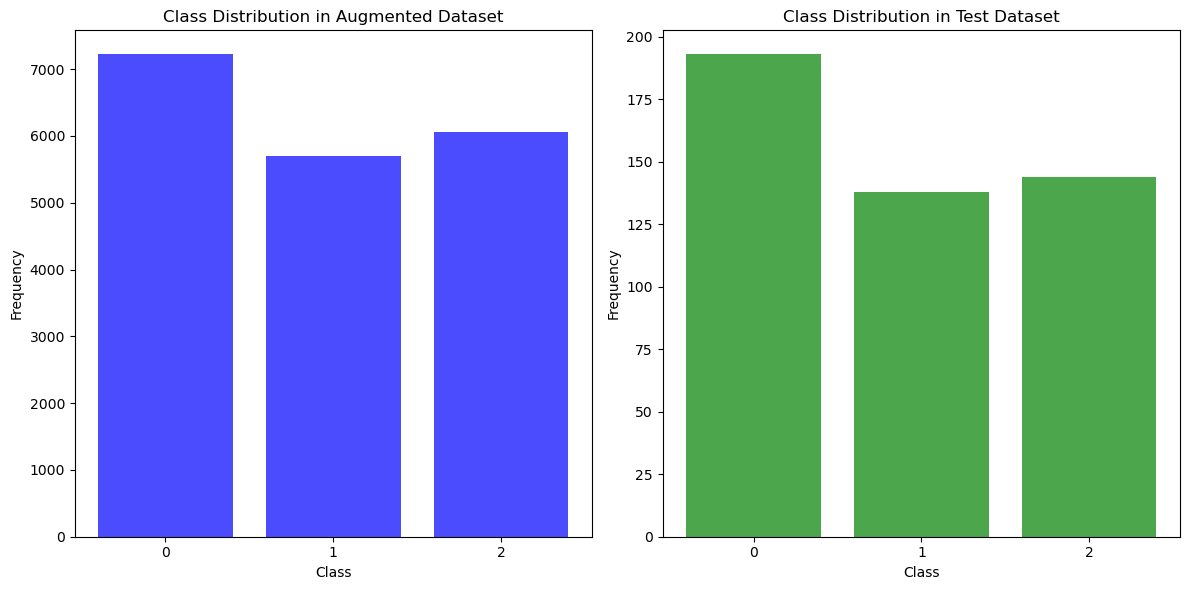

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_augmented and y_test are numpy arrays or lists
classes_augmented, counts_augmented = np.unique(y_aug, return_counts=True)
classes_test, counts_test = np.unique(y_test, return_counts=True)

# Create a bar chart for the augmented data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(classes_augmented, counts_augmented, color='blue', alpha=0.7)
plt.title('Class Distribution in Augmented Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(classes_augmented)

# Create a bar chart for the test data
plt.subplot(1, 2, 2)
plt.bar(classes_test, counts_test, color='green', alpha=0.7)
plt.title('Class Distribution in Test Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(classes_test)

# Show the plots
plt.tight_layout()
plt.show()


## (No PCA) Not Filtered - augmented data was used to train the model and the original data (test) was used to evaluate it.

In [40]:
if DO_ML:
    print("Building machine learning models...")
    ml_models = build_ml_models()
    print("Training and evaluating machine learning models...")
    # Example usage with the original test set
    results = train_and_evaluate_ml_models(
        models=ml_models,
        X_augmented=X_aug,
        y_augmented=y_aug,
        X_test=X_test,
        y_test=y_test,
        apply_pca=False,
        pca_variance_threshold=0.99,
        apply_filters_bg_subtraction=False,
        cv=5,
        standardize_data_func=standardize_data
    )


Building machine learning models...
Training and evaluating machine learning models...
Training SVM model on fold...
Evaluating SVM model on original data...
Training SVM model on fold...
Evaluating SVM model on original data...
Training SVM model on fold...
Evaluating SVM model on original data...
Training SVM model on fold...
Evaluating SVM model on original data...
Training SVM model on fold...
Evaluating SVM model on original data...

SVM Model Results:
CV: 5
Accuracy: 0.7086315789473685
Precision: 0.7020319031796243
Recall: 0.6929810893344347
F1 Score: 0.695429640973835
Confusion Matrix: 
[[161.   15.2  16.8]
 [ 29.4  83.8  24.8]
 [ 28.2  24.   91.8]]

TP_TN_FP_FN: 
[{0: (0.3389473684210526, 0.9988963988919667, 0.11789473684210526, 0.06736842105263158), 1: (0.17894736842105263, 0.999202216066482, 0.08842105263157894, 0.11157894736842106), 2: (0.18947368421052632, 0.999180055401662, 0.0863157894736842, 0.11368421052631579)}, {0: (0.3389473684210526, 0.9988875346260387, 0.1221052631

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating Logistic Regression model on original data...
Training Logistic Regression model on fold...


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating Logistic Regression model on original data...
Training Logistic Regression model on fold...


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating Logistic Regression model on original data...
Training Logistic Regression model on fold...


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating Logistic Regression model on original data...
Training Logistic Regression model on fold...


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating Logistic Regression model on original data...

Logistic Regression Model Results:
CV: 5
Accuracy: 0.720421052631579
Precision: 0.7059348439572832
Recall: 0.7041335010387725
F1 Score: 0.7043349551786435
Confusion Matrix: 
[[164.8  12.8  15.4]
 [ 19.2  88.   30.8]
 [ 19.8  34.8  89.4]]

TP_TN_FP_FN: 
[{0: (0.3452631578947368, 0.9989717451523547, 0.08210526315789474, 0.061052631578947365), 1: (0.18736842105263157, 0.999171191135734, 0.1031578947368421, 0.1031578947368421), 2: (0.1831578947368421, 0.999153462603878, 0.09894736842105263, 0.12)}, {0: (0.3494736842105263, 0.9989761772853186, 0.08, 0.056842105263157895), 1: (0.19789473684210526, 0.9991623268698061, 0.10736842105263159, 0.09263157894736843), 2: (0.18105263157894738, 0.999184487534626, 0.08421052631578947, 0.12210526315789473)}, {0: (0.3431578947368421, 0.9989806094182826, 0.07789473684210527, 0.06315789473684211), 1: (0.18526315789473685, 0.9991623268698061, 0.10736842105263159, 0.10526315789473684), 2: (0.1873684210

## (No PCA) Filtered - augmented data was used to train the model and the original data (test) was used to evaluate it.

In [16]:
if DO_ML:
    print("Building machine learning models...")
    ml_models = build_ml_models()
    print("Training and evaluating machine learning models...")
    # Example usage with the original test set
    results = train_and_evaluate_ml_models(
        models=ml_models,
        X_augmented=X_aug,
        y_augmented=y_aug,
        X_test=X_test,
        y_test=y_test,
        apply_pca=False,
        pca_variance_threshold=0.95,
        apply_filters_bg_subtraction=True,
        cv=5,
        standardize_data_func=standardize_data
    )

Building machine learning models...
Training and evaluating machine learning models...
Training SVM model on fold...
Evaluating SVM model on original data...
Training SVM model on fold...
Evaluating SVM model on original data...
Training SVM model on fold...
Evaluating SVM model on original data...
Training SVM model on fold...
Evaluating SVM model on original data...
Training SVM model on fold...
Evaluating SVM model on original data...

SVM Model Results:
CV: 5
Accuracy: 0.6854736842105262
Precision: 0.6799055050745096
Recall: 0.668603309887946
F1 Score: 0.6712968759025284
Confusion Matrix: 
[[158.4  16.4  18.2]
 [ 35.2  79.4  23.4]
 [ 30.8  25.4  87.8]]

TP_TN_FP_FN: 
[{0: (0.33263157894736844, 0.9988565096952908, 0.1368421052631579, 0.07368421052631578), 1: (0.16842105263157894, 0.99918891966759, 0.09473684210526316, 0.12210526315789473), 2: (0.17894736842105263, 0.999175623268698, 0.08842105263157894, 0.12421052631578948)}, {0: (0.33473684210526317, 0.9988387811634349, 0.145263157

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating Logistic Regression model on original data...
Training Logistic Regression model on fold...


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating Logistic Regression model on original data...
Training Logistic Regression model on fold...


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating Logistic Regression model on original data...
Training Logistic Regression model on fold...


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating Logistic Regression model on original data...
Training Logistic Regression model on fold...


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating Logistic Regression model on original data...

Logistic Regression Model Results:
CV: 5
Accuracy: 0.6917894736842104
Precision: 0.6796489129221504
Recall: 0.6757860670988628
F1 Score: 0.6765161456157297
Confusion Matrix: 
[[158.2  13.8  21. ]
 [ 26.2  80.6  31.2]
 [ 23.2  31.   89.8]]

TP_TN_FP_FN: 
[{0: (0.33052631578947367, 0.9989540166204985, 0.09052631578947369, 0.07578947368421053), 1: (0.17684210526315788, 0.9991667590027701, 0.10526315789473684, 0.11368421052631579), 2: (0.19157894736842104, 0.9991401662049861, 0.10526315789473684, 0.11157894736842106)}, {0: (0.3263157894736842, 0.9989318559556787, 0.10105263157894737, 0.08), 1: (0.16842105263157894, 0.9992066481994459, 0.0863157894736842, 0.12210526315789473), 2: (0.1957894736842105, 0.9991047091412742, 0.12210526315789473, 0.10736842105263159)}, {0: (0.3368421052631579, 0.9989096952908587, 0.11157894736842106, 0.06947368421052631), 1: (0.1705263157894737, 0.999197783933518, 0.09052631578947369, 0.12), 2: (0.18526315

## (PCA) Not Filtered - augmented data was used to train the model and the original data (test) was used to evaluate it.

In [51]:
if DO_ML:
    print("Building machine learning models...")
    ml_models = build_ml_models()
    print("Training and evaluating machine learning models...")
    # Example usage with the original test set
    results = train_and_evaluate_ml_models(
        models=ml_models,
        X_augmented=X_aug,
        y_augmented=y_aug,
        X_test=X_test,
        y_test=y_test,
        apply_pca=True,
        pca_variance_threshold=0.99,
        apply_filters_bg_subtraction=False,
        cv=5,
        standardize_data_func=standardize_data
    )

Building machine learning models...
Training and evaluating machine learning models...
Training SVM model on fold...
Evaluating SVM model on original data...
Training SVM model on fold...
Evaluating SVM model on original data...
Training SVM model on fold...
Evaluating SVM model on original data...
Training SVM model on fold...
Evaluating SVM model on original data...
Training SVM model on fold...
Evaluating SVM model on original data...

SVM Model Results:
CV: 5
Accuracy: 0.5835789473684211
Precision: 0.5718525899740142
Recall: 0.5550131202389593
F1 Score: 0.5517940837958916
Confusion Matrix: 
[[158.2  18.2  16.6]
 [ 47.8  62.8  27.4]
 [ 53.6  34.2  56.2]]

TP_TN_FP_FN: 
[{0: (0.33052631578947367, 0.9986925207756233, 0.21473684210526317, 0.07578947368421053), 1: (0.13052631578947368, 0.999153462603878, 0.11157894736842106, 0.16), 2: (0.12, 0.9991667590027701, 0.09263157894736843, 0.1831578947368421)}, {0: (0.3389473684210526, 0.9986925207756233, 0.21473684210526317, 0.0673684210526315

## (PCA) Filtered - augmented data was used to train the model and the original data (test) was used to evaluate it.

In [52]:
if DO_ML:
    print("Building machine learning models...")
    ml_models = build_ml_models()
    print("Training and evaluating machine learning models...")
    # Example usage with the original test set
    results = train_and_evaluate_ml_models(
        models=ml_models,
        X_augmented=X_aug,
        y_augmented=y_aug,
        X_test=X_test,
        y_test=y_test,
        apply_pca=True,
        pca_variance_threshold=0.99,
        apply_filters_bg_subtraction=True,
        cv=5,
        standardize_data_func=standardize_data
    )

Building machine learning models...
Training and evaluating machine learning models...
Training SVM model on fold...
Evaluating SVM model on original data...
Training SVM model on fold...
Evaluating SVM model on original data...
Training SVM model on fold...
Evaluating SVM model on original data...
Training SVM model on fold...
Evaluating SVM model on original data...
Training SVM model on fold...
Evaluating SVM model on original data...

SVM Model Results:
CV: 5
Accuracy: 0.5797894736842106
Precision: 0.5693653928760587
Recall: 0.5507828339716152
F1 Score: 0.5476030412878241
Confusion Matrix: 
[[158.   19.2  15.8]
 [ 49.6  61.   27.4]
 [ 54.6  33.   56.4]]

TP_TN_FP_FN: 
[{0: (0.32842105263157895, 0.9986969529085873, 0.21263157894736842, 0.07789473684210527), 1: (0.13052631578947368, 0.9991490304709141, 0.11368421052631579, 0.16), 2: (0.12210526315789473, 0.9991667590027701, 0.09263157894736843, 0.18105263157894738)}, {0: (0.3410526315789474, 0.9986792243767314, 0.22105263157894736, 0